# Planteamiento del problema

La evolución de la inteligencia artificial es grande, y cada vez está impactando la forma de trabajar en diferentes áreas. Tal es el caso del área sanitaria y de salud, donde está revolucionando la atención en áreas como:

* Diagnóstico de enfermedades con imágenes médicas.
* Robots quirúrgicos.
* Maximización de la eficiencia hospitalaria.

Se espera que el mercado de la salud de la Inteligencia Artificial alcance los $45.2 mil millones de dólares para el 2026, 

La valoración actual es de $4.9 mil millones.

Se ha demostrado que la aplicación de Inteligencia Artificial, principalmente el aprendizaje profundo es superior en la detección de enfermedades a partir de rayos X, resonancias magnéticas y tomografías computarizadas, lo que podría mejorar significativamente la velocidad y precisión del diagnóstico.

Para un mejor enfoque: https://research.aimultiple.com/looking-for-better-medical-imaging-for-early-diagnostic-and-monitoring-contact-the-leading-vendors-here/

En este caso de estudio asumiremos que se está trabajando como consultor de IA/ML y se nos ha contratado por una empresa de diagnóstico médico en Nueva York.

Se ha asignado la tarea de mejorar la velocidad y precisión de la detección y localización de tumores cerebrales en función de las imágenes por resonancia magnética.

El objetivo es reducir el costo y ayudar en el diagnóstico temprano de tumores, lo que esencialmente aumentaría la probabilidad de un tratamiento con éxito.

El equipo se dio a la tarea de recopilar imágenes por resonancia magnética del cerebro, son un total de 3929 imágenes cerebrales con las que se disponen para desarrollar el algoritmo.

Fuente original de los datos: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation

**Pipeline de aprendizaje profundo en capas para realizar clasificación y localización**

Se llevarán a cabo dos etapas para lograr detectar y localizar el tumor cerebral (en caso de que exista uno).

1. Uso de una ResNet para clasificar las imágenes en:
  - 0: No existe tumor.
  - 1: Existe tumor.

2. Una vez terminado este proceso, la etapa siguiente es distinta según el resultado obtenido en la primera etapa:
  - Si el resultado es 1: La imagen servirá de input para un modelo de segmentación apoyado con una ResUNet que nos ayude a localizar el tumor.
  - Si el resultado es 0: Se considera como paciente sano, por lo que no es necesario someter la imagen a la segunda etapa.

**Una reseña de, que es la segmentación de imágenes**

El objetivo de la segmentación de imágenes es comprender y extraer la información de las imágenes a nivel pixel. Se puede utilizar para el reconocimiento y la localización de objetos, lo que ofrece un gran valor en aplicaciones relacionadas con imágenes médicas y automóviles autónomos.

El objetivo de la segmentación de imágenes es entrenar una red neuronal para producir una máscara de píxeles de la imagen, resaltando la parte donde se encuentra el objeto que se quiere detectar y localizar.

# Importar librerías y datasets

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import cv2
from skimage import io

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, AveragePooling2D, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization, ReLU, Input, Activation, Add, UpSampling2D, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

import os
import random
%matplotlib inline

In [ ]:
# Datos que contienen la ruta a Brain MRI y su máscara correspondiente
brain_df = pd.read_csv('./data/data_mask.csv')
brain_df.head()

patient_id                                         image_path  \
0  TCGA_CS_5395_19981004  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1  TCGA_CS_5395_19981004  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2  TCGA_CS_5395_19981004  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3  TCGA_CS_5395_19981004  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4  TCGA_CS_5395_19981004  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   

                                           mask_path  mask  
0  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0

Vamos a entender el conjunto de datos.

* **patient_id**: Hace referencia al Id del paciente al cual fue tomada la resonancia magnética.
* **image_path**: Nos proporciona el path de donde la imagen ha sido guardada.
* **mask_path**: Nos proporciona el path donde la máscara ha sido guardada.
* **mask**: Valor binario donde 0 significa ausencia de tumores, 1 presencia de tumores.

In [ ]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


Con la información de arriba podemos verificar que no existen datos nulos dentro del dataset.

Tomando en cuenta los datos, verifiquemos cuantos de estos están catalogados como pacientes sanos (mask = 0) y cuantos se les detectó algún tipo de tumor (mask = 1).

In [ ]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

Tenemos un dataset con 2556 pacientes sanos y 1373 con algún tipo de tumor.

Este es un conjunto de datos desbalanceado, es decir, el número de ejemplos por categoría son muy distintos lo que puede ocasionar un mal entrenamiento de nuestro modelo clasificador. Es necesario que antes de comenzar con el entrenamiento el conjunto de datos sea parecido para ambas categorías.

## Visualización de datos

Visualicemos en un gráfico de barras la distribución de pacientes sanos y pacientes con algún tipo de tumor.

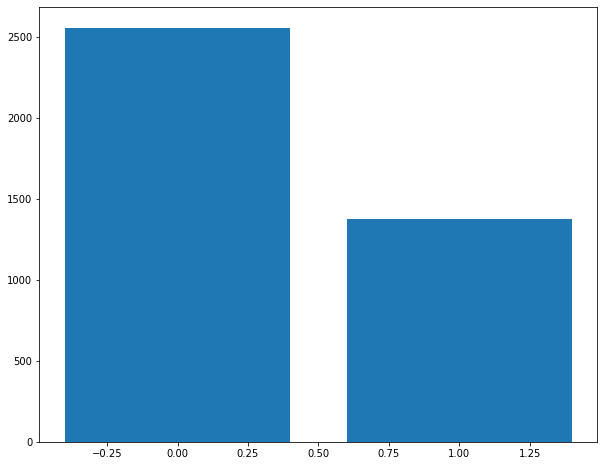

In [ ]:
plt.figure(figsize=(10,8))
plt.bar(brain_df['mask'].value_counts().index, brain_df['mask'].value_counts())
plt.show()

En la gráfica podemos observar como el dataset está desbalanceado, donde el número de pacientes sanos es mayor al número de pacientes con algún tipo de tumor, al momento del entrenamiento nuestro modelo puede adquirir un poco de sesgo, va a traducir que existe una mayor probabilidad de que un paciente este sano. Esto no es correcto, tenemos que suministrarle los datos sabiendo que las probabilidades de estar sano o tener algún tipo de tumor es la misma.

**Visualicemos algunas imágenes**

Recordemos que nuestro dataset se compone de los path donde se encuentra guardadas las imágenes, podemos acceder a estos y así visualizar la tomografía con su respectiva máscara.

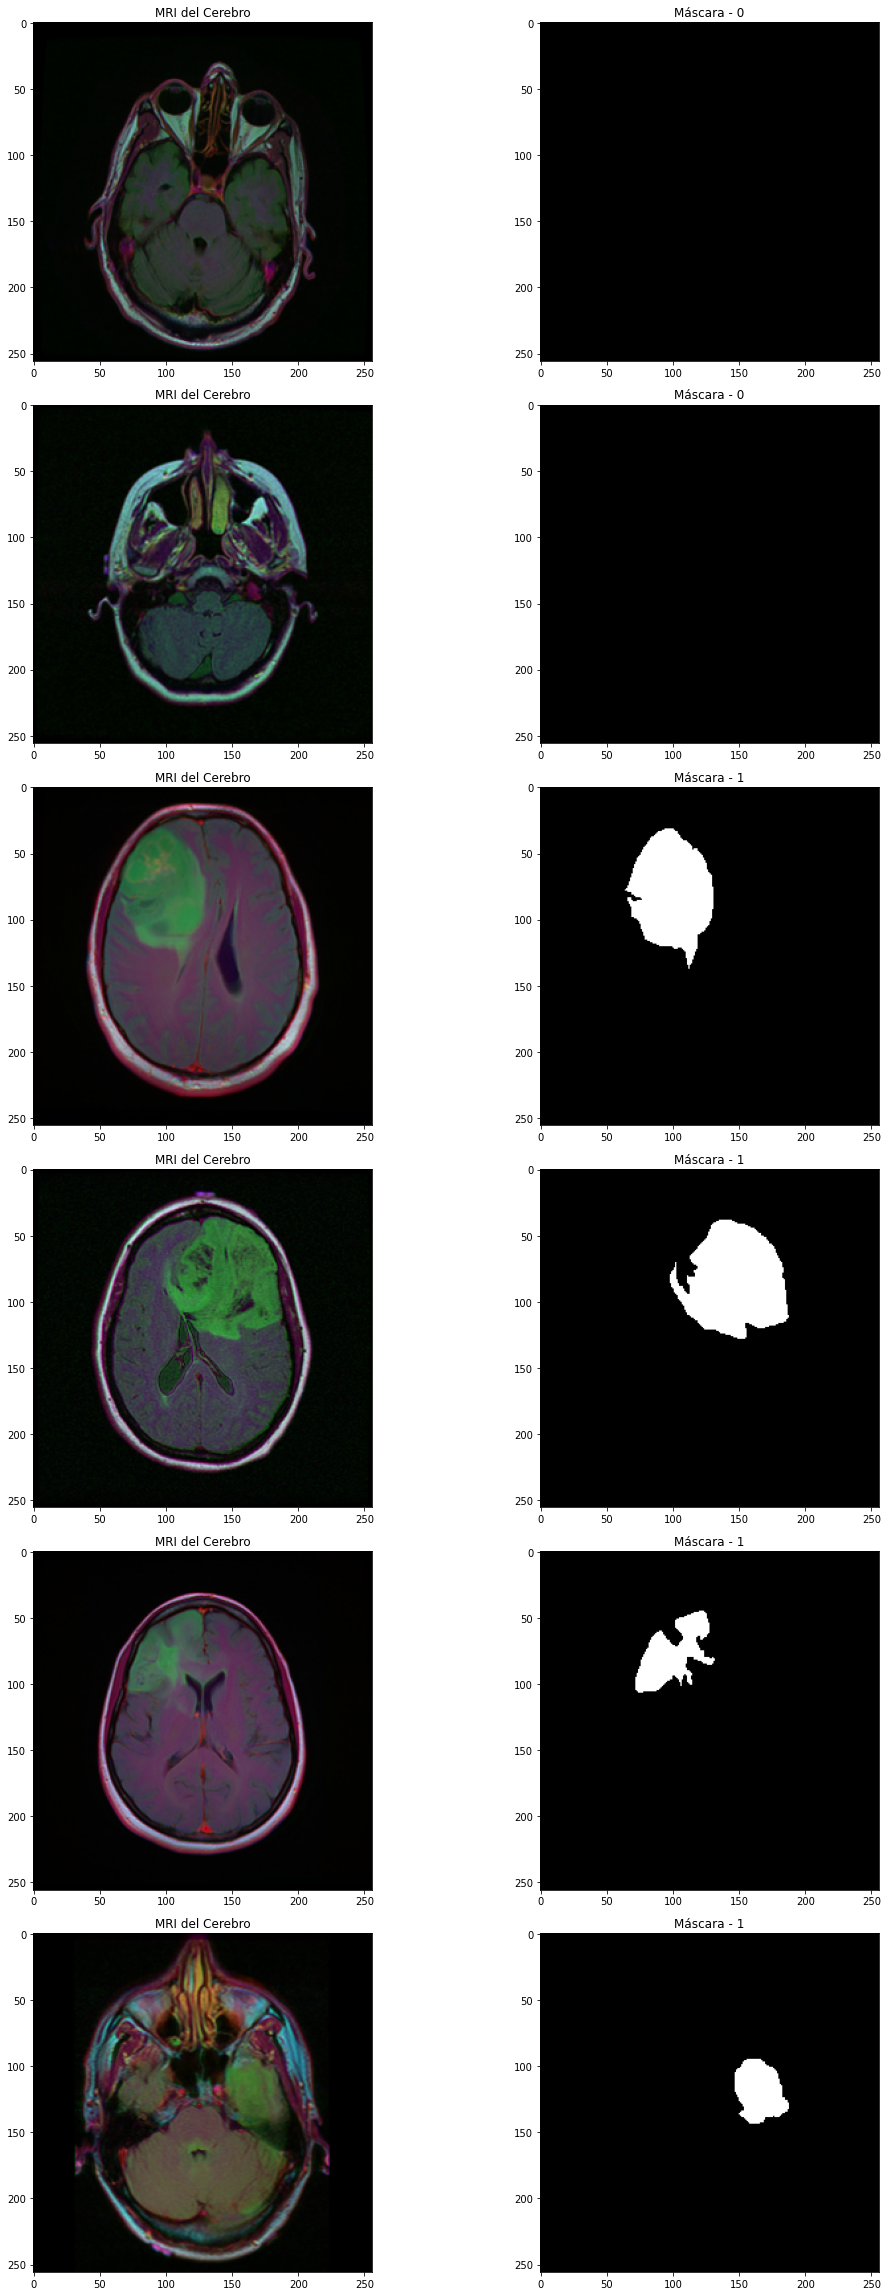

In [ ]:
# Visualizar 6 imágenes con su respectiva máscara
import random
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
    # Seleccionamos un índice aleatorio
    i = random.randint(0, len(brain_df)) 

    axs[count][0].title.set_text("MRI del Cerebro")
    axs[count][0].imshow(cv2.imread('./data/{}'.format(brain_df.image_path[i])))
    axs[count][1].title.set_text("Máscara - " + str(brain_df['mask'][i]))
    axs[count][1].imshow(cv2.imread('./data/{}'.format(brain_df.mask_path[i])))

    count += 1

fig.tight_layout()

Para que se entienda de una mejor manera lo que representa una máscara, optamos por sobreponerla en la imagen de la resonancia para visualizar en que parte del cerebro se encuentra el tumor, si es que este existe.

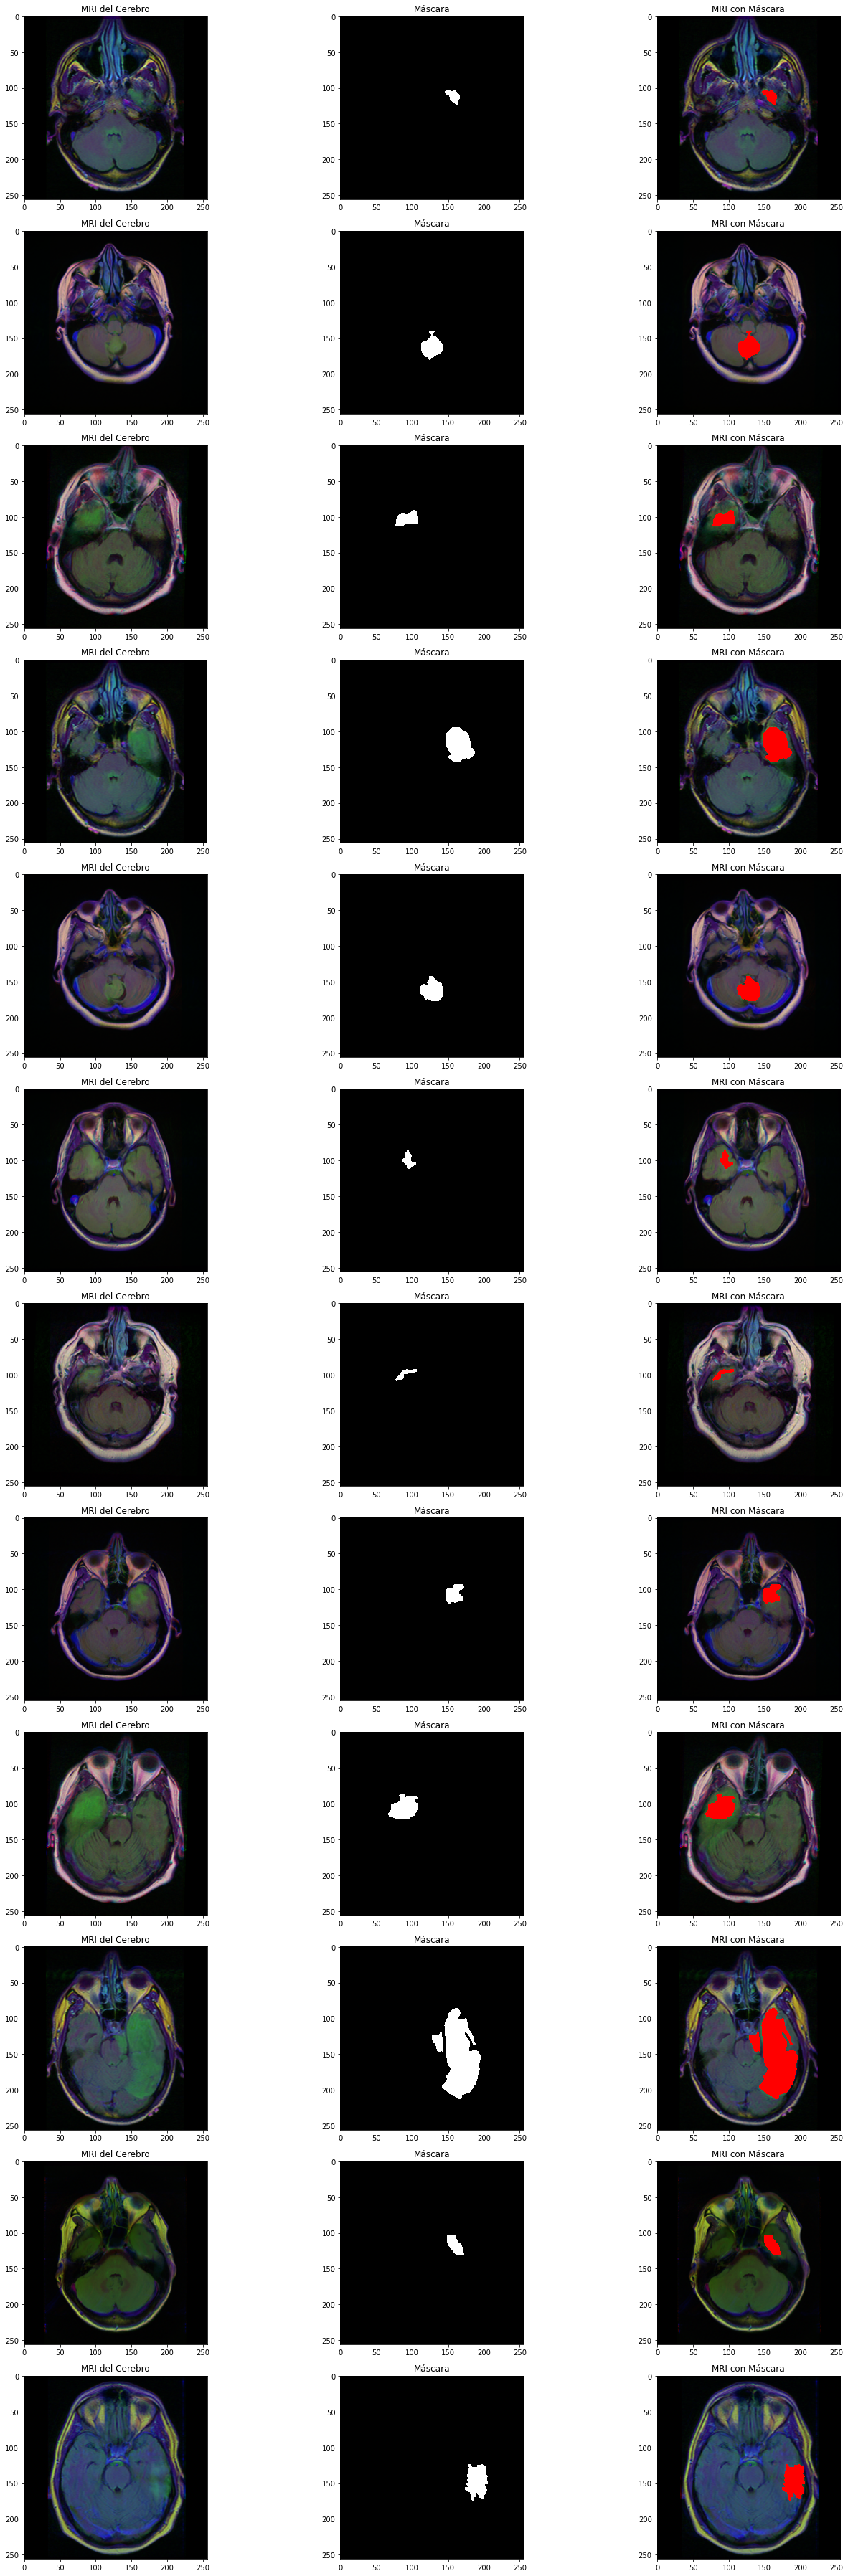

In [ ]:
count = 0
fig, axs = plt.subplots(12, 3, figsize = (20, 50))
for i in range(len(brain_df)):
    if brain_df['mask'][i] == 1 and count < 12:
        img = io.imread('./data/{}'.format(brain_df.image_path[i]))
        axs[count][0].title.set_text('MRI del Cerebro')
        axs[count][0].imshow(img)

        mask = io.imread('./data/{}'.format(brain_df.mask_path[i]))
        axs[count][1].title.set_text('Máscara')
        axs[count][1].imshow(mask, cmap='gray')

        # Cambiamos la máscara a RGB y resaltamos el color rojo
        img[mask == 255] = (255, 0, 0)
        axs[count][2].title.set_text('MRI con Máscara')
        axs[count][2].imshow(img)
        count+=1

fig.tight_layout()

## Limpieza de datos

La columna de id del paciente no es necesaria, procedemos a eliminarla.

In [ ]:
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

Tensorflow, en su función de flow_from_dataframe requiere que la variable a predecir esté en formato string, actualmente se encuentra en formato numérico.

In [ ]:
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [ ]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


## Balanceando el conjunto de datos

Para lograr tener un conjunto de datos balanceado la técnica que se usará será en disminuir el tamaño de datos de pacientes sanos a 1400, número cercano a los pacientes con algún tipo de tumor.

In [ ]:
# Obteniendo sólo los pacientes sanos
healthy_patient = brain_df_train[brain_df_train['mask'] == '0'].reset_index()

# Seleccionar al azar 1400 pacientes
range_list = np.arange(0, len(healthy_patient))
to_select = np.random.choice(range_list, 1400, replace=False)

# Nos quedamos con los pacientes seleccionados
healthy_patient_to_train = healthy_patient.iloc[to_select, :]

In [ ]:
# Obteniendo solo los pacientes con tumor
unhealthy_patient = brain_df_train[brain_df_train['mask'] == '1'].reset_index()

# Concatenamos los datafames
brain_df_balanced = pd.concat([healthy_patient_to_train, unhealthy_patient]).reset_index()

Verifiquemos con una gráfica si el dataframe quedó balanceado

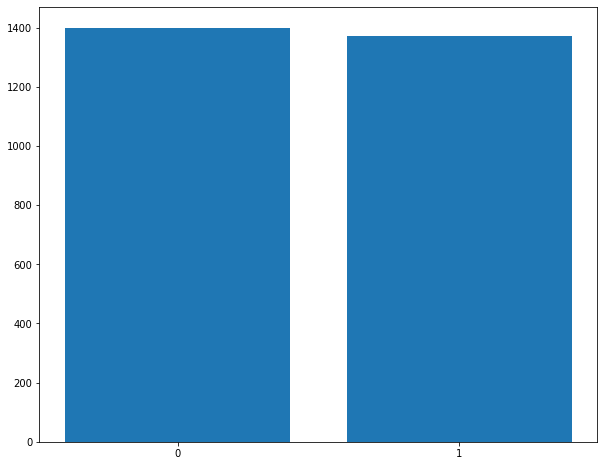

In [ ]:
plt.figure(figsize=(10,8))
plt.bar(brain_df_balanced['mask'].value_counts().index, brain_df_balanced['mask'].value_counts())
plt.show()

# Entrenar un modelo clasificador

El objetivo de este modelo será detectar si en la resonancia magnética existe la presencia de un tumor o no.

## Construir el conjunto de entrenamiento y de test.

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_balanced, test_size = 0.15, shuffle=True)

### Pre Procesado de los datos

Antes de iniciar con el entrenamiento es necesario normalizar los datos, nos ayudaremos con el Image Dta Generator de Keras, además crearemos los conjuntos para entrenamiento, validación y testing.

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255.,
                             validation_split = 0.15)

test_datagen=ImageDataGenerator(rescale=1./255.)

In [ ]:
# Conjunto de entrenamiento
train_generator = datagen.flow_from_dataframe(
    dataframe=train,
    directory='./data/',
    x_col='image_path',
    y_col='mask',
    subset='training',
    batch_size=16,
    shuffle=True,
    class_mode='binary',
    target_size=(256,256)
)

# Cunjunto de validación
valid_generator = datagen.flow_from_dataframe(
    dataframe=train,
    directory='./data/',
    x_col='image_path',
    y_col='mask',
    subset='validation',
    batch_size=16,
    shuffle=True,
    class_mode='binary',
    target_size=(256,256)
)

# Conjunto de test
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory='./data/',
    x_col='image_path',
    y_col='mask',
    batch_size=16,
    class_mode='binary',
    target_size=(256,256)
)

Found 2004 validated image filenames belonging to 2 classes.
Found 353 validated image filenames belonging to 2 classes.
Found 416 validated image filenames belonging to 2 classes.


## Modelo de entrenamiento

Para el entrenamiento del modelo utilizaremos la arquitectura de ResNet, para mayor información puede consultar el [papaer](https://arxiv.org/pdf/1512.03385.pdf) o el siguiente [artículo](https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33).

**Arquitectura del modelo:**

* **Primera capa:**
  * Capa de convolución con 32 filtros de tamaño 3, stride de 1 y padding valid.
  * Capa de Batch Normalization
  * Capa de MaxPooling, poolsize de 2
  * Capa ReLu

* **Segunda capa:**
  * Capa de convolución con 64 filtros de tamaño 3, stride de 1 y padding valid.
  * Capa de Batch Normalization
  * Capa de MaxPooling, poolsize de 2
  * Capa ReLu

Las primeras dos capas nos ayudan además de reducir el tamaño de la imagen, a encontrar los primeros patrones lineales como patrones horizontales, verticales, entre otros.

* Tres bloques ResNet con 64, 128, 256 filtros respectivamente, estas capas nos ayudarán a encontrar patrones más específicos para identificar el tumor.

* **Tercera capa:**
  * Capa de convolución con 256 filtros de tamaño 3, stride de 1 y padding valid.
  * Capa de Batch Normalization
  * Capa de MaxPooling, poolsize de 2
  * Capa ReLu

* Capa de AveragePooling
* Capa Flatten

* Capas Fully Connected
  * Primera capa densa con 128 neuronas y activación ReLu.
  * Batch Normalization para ayudar en el entrenamiento.
  * Droput del 20% para evitar el overfitting.
  * Segunda capa densa con 128 neuronas y activación ReLu.
  * Batch Normalization para ayudar en el entrenamiento.
  * Droput del 20% para evitar el overfitting.
  * Tercera capa densa con 128 neuronas y activación ReLu.
  * Batch Normalization para ayudar en el entrenamiento.

* Capa de predicción con 1 neurona y activación sigmoide.

In [ ]:
def resblock(X, f):
    '''
    Function to create a resblock where:
    - X_shortcut is equal to the inputs X
    - For X:
      - Conv2D(f, kernel_size=1, stride=1, kernel_initializer='he_normal')
      - BatchNormalization() and ReLu activation
      - Conv2D(f, kernel_size=1, stride=1, padding='same', kernel_initializer='he_normal')
      - BatchNormalization()
    - For X_shortcut:
      - Conv2D(f, kernel_size=1, stride=1, padding='same', kernel_initializer='he_normal')
      - BatchNormalization()
    - X = Add()([X, X_shortcut]).
    - ReLu activation
    **Args:**
    - X: output for the previous layer
    - f: filters number to apply on the resblock
    **Returns:**
    - resblock X
    '''
    # Hacemos la copia de la entrada
    X_shortcut = X

    # Ruta principal
    X = Conv2D(f, kernel_size=(1,1) ,strides=(1,1),kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X) 

    X = Conv2D(f, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)

    # Ruta corta
    X_shortcut = Conv2D(f, kernel_size=(1,1), strides=(1,1), kernel_initializer='he_normal')(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)

    # Agregar la salida de la ruta principal y la ruta corta juntas
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
INPUT_SHAPE = (256,256,3)
inputs = Input(shape=INPUT_SHAPE, name='input_layer')

# Capa 1
x = Conv2D(filters=32, kernel_size=3, strides=(1,1), padding='valid', name='cov_layer_1')(inputs)
x = BatchNormalization(name='batchNorm_layer_1')(x)
x = MaxPooling2D(pool_size=(2,2), name='MaxPooling_layer_1')(x)
x = ReLU(name='ReLu_layer_1')(x)

# Capa 2
x = Conv2D(filters=64, kernel_size=3, strides=(1,1), padding='valid', name='cov_layer_2')(x)
x = BatchNormalization(name='batchNorm_layer_2')(x)
x = MaxPooling2D(pool_size=(2,2), name='MaxPooling_layer_2')(x)
x = ReLU(name='ReLu_layer_2')(x)

# Bloque 1
x = resblock(x, 64)

# Bloque 2
x = resblock(x, 128)

# Bloque 3
x = resblock(x, 256)

# Capa 3
x = Conv2D(filters=256, kernel_size=3, strides=(1,1), padding='valid', name='cov_layer_3')(x)
x = BatchNormalization(name='batchNorm_layer_3')(x)
x = MaxPooling2D(pool_size=(2,2), name='MaxPooling_layer_3')(x)
x = ReLU(name='ReLu_layer_3')(x)

# Average Pooling
x = AveragePooling2D(pool_size=(2,2), name='Final_AveragePooling')(x)

# Capa Flatten
x = Flatten(name='Flatten_layer')(x)

# Capa FC
x = Dense(128, activation='relu', name='FC_layer_1')(x)
x = BatchNormalization(name='batchNorm_FC_layer_1')(x)
x = Dropout(0.2, name='Dropout_FC_layer_1')(x)
x = Dense(128, activation='relu', name='FC_layer_2')(x)
x = BatchNormalization(name='batchNorm_FC_layer_2')(x)
x = Dropout(0.2, name='Dropout_FC_layer_2')(x)
x = Dense(64, activation='relu', name='FC_layer_3')(x)
x = BatchNormalization(name='batchNorm_FC_layer_3')(x)

outputs = Dense(1, activation='sigmoid', name='Outputs')(x)

model_res = Model(inputs=inputs, outputs=outputs)

model_res.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 cov_layer_1 (Conv2D)           (None, 254, 254, 32  896         ['input_layer[0][0]']            
                                )                                                                 
                                                                                                  
 batchNorm_layer_1 (BatchNormal  (None, 254, 254, 32  128        ['cov_layer_1[0][0]']            
 ization)                       )                                                           

In [ ]:
# Learning rate scheduler para un mejor entrenamiento
def scheduler(epoch, lr):
    '''
    Function to make a learning rate sheduler
    **Args:**
    - epoch: Training epoch number
    - lr: Current learning rate of the optimizer algorithm
    **Return:**
    - Current learning rate if the epoch number is less than 20
    - Fine tuning learning rate if the epoch es equal or grader than 20
    '''
    if epoch < 20:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
# Compilación del modelo
model_res.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])

# Guardamos el mejor modelo con la menor pérdida de validación
checkpointer = ModelCheckpoint(filepath="classifier-weights_res.hdf5", verbose=1, save_best_only=True)
# Lr scheduler callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Entrenamiento del modelo
history_res = model_res.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs=40,
                    validation_data=valid_generator, validation_steps= valid_generator.n // 16,
                    callbacks=[checkpointer, lr_scheduler])

Epoch 1/40
125/125 [==============================] - ETA: 0s - loss: 0.6730 - accuracy: 0.6665
Epoch 1: val_loss improved from inf to 1.42052, saving model to classifier-weights_res.hdf5
125/125 [==============================] - 24s 167ms/step - loss: 0.6730 - accuracy: 0.6665 - val_loss: 1.4205 - val_accuracy: 0.5085 - lr: 0.0010
Epoch 2/40
125/125 [==============================] - ETA: 0s - loss: 0.5735 - accuracy: 0.7289
Epoch 2: val_loss improved from 1.42052 to 0.87298, saving model to classifier-weights_res.hdf5
125/125 [==============================] - 20s 159ms/step - loss: 0.5735 - accuracy: 0.7289 - val_loss: 0.8730 - val_accuracy: 0.5057 - lr: 0.0010
Epoch 3/40
125/125 [==============================] - ETA: 0s - loss: 0.5208 - accuracy: 0.7525
Epoch 3: val_loss did not improve from 0.87298
125/125 [==============================] - 19s 148ms/step - loss: 0.5208 - accuracy: 0.7525 - val_loss: 1.0115 - val_accuracy: 0.4943 - lr: 0.0010
Epoch 4/40
125/125 [================

Hemos logrado obtener un modelo balanceado, consiguiendo buenos resultados tanto en el conjunto de entrenamiento como en el de validación.

Para corroborar esto verifiquemos las gráficas de comportamiento de las métricas.

In [ ]:
def plot_metrics(history):
    '''
    Function to plot the metrics arround the epoch

    **Args:**:
    * history: The model history list with accuray, loss, val_accuracy and val_loss values
    '''
    metrics = []
    for metric in history.keys():
        metrics.append(metric)

    loss = history[metrics[0]]
    accuracy = history[metrics[1]]
    val_loss = history[metrics[2]]
    val_accuracy = history[metrics[3]]

    plt.figure(figsize=(20,8))
    plt.subplot(1,2,1)
    plt.plot(accuracy, label='Train accuracy')
    plt.plot(val_accuracy, label='Validation accuracy')
    plt.title('Train accuracy vs Validation accuracy')
    plt.legend(loc='best')
    plt.subplot(1,2,2)
    plt.plot(loss, label='Train loss')
    plt.plot(val_loss, label='Validation loss')
    plt.title('Train loss vs Validation loss')
    plt.legend(loc='best')

    plt.show()

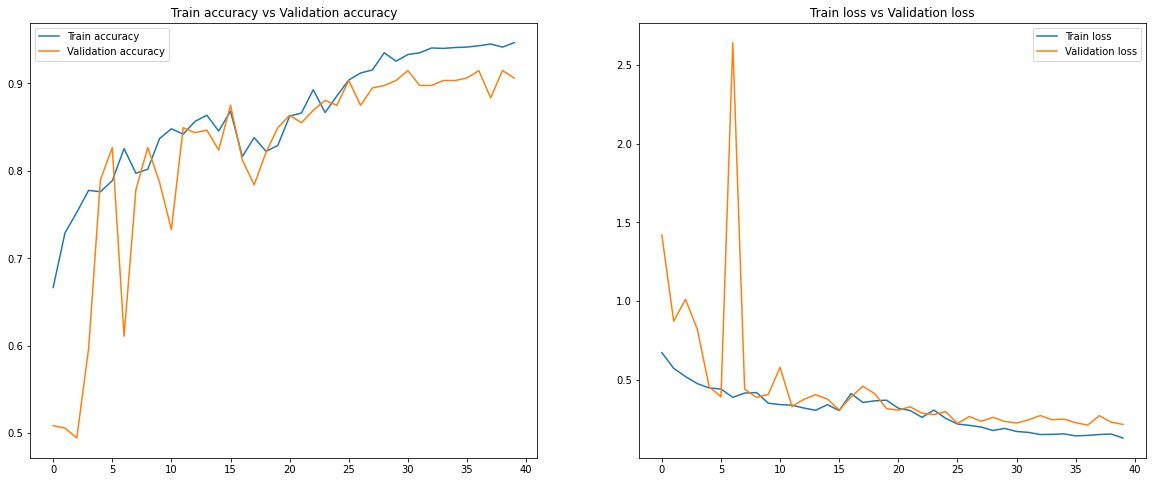

In [ ]:
plot_metrics(history_res.history)

Podemos obtener las siguientes conclusiones en base a las gráficas de arriba:

* El accuracy para el conjunto de entrenamiento mejora época a época. En el conjunto de validación observamos la misma tendencia, consiguiendo en ambos conjuntos una buena métrica.
* La pérdida en el conjunto de entrenamiento se mantuvo disminuyendo cada época, observamos la misma tendencia en el conjunto de validación.

Gracias al checkpointer conseguimos guardar los pesos donde en el conjunto de validación se obtuvo la menor pérdida.

In [ ]:
model_res.evaluate(test_generator)

26/26 [==============================] - 103s 4s/step - loss: 0.2373 - accuracy: 0.8942


[0.2372908741235733, 0.8942307829856873]

In [ ]:
# Guardamos la arquitectura del modelo en un archivo json para uso futuro
model_json = model_res.to_json()
with open("classifier_model_res.json","w") as json_file:
    json_file.write(model_json)

## Evaluación del modelo

In [ ]:
import json
# Cargamos el modelo preentrenado
with open('classifier_model_res.json', 'r') as json_file:
    json_savedModel = json_file.read()

model_res = tf.keras.models.model_from_json(json_savedModel)
model_res.load_weights('classifier-weights_res.hdf5')
model_res.compile(loss = 'binary_crossentropy', optimizer='adam', metrics= ["accuracy"])

**Métricas de evaluación**

Es turno de hacer unas predicciones, para ello utilizaremos el dataset de testing, pasaremos imagen por imagen al modelo para hacer la predicción de la misma, al final verificaremos con una matriz de confusión para evaluar la precisión, recall y f1-score.

In [ ]:
def make_predictions(model, image_paths, threshold=0.5):
    '''
    Funtion to make predictions according one model already trained.
    **Args**:
    * model: Model already trained
    * image_paths: The path where the images are saved,
    * threshold: For binary classification models, threshold to be take in care to decide if
    a prediction is 1 or 0.
    **Returs**:
    It returns a list of prediction, 0 or 1 in string format due flow from dataset test_generator
    '''  
    predictions = []
    for path in image_paths:
        # Leemos la imágen y normalizamos sus valores
        img = io.imread('./data/{}'.format(path))
        img = img / 255.
        # Transformamos la imágen a tensor de la forma [m, h, w, c]
        img = tf.reshape(img, shape=[1, img.shape[0], img.shape[1], img.shape[2]])
        # Aplicamos la predicción
        pred = model.predict(img)
        # Guardamos 0 o 1 de acuerdo a la probabilidad.
        if pred[0][0] >= threshold:
            predictions.append(str(1))
        else:
            predictions.append(str(0))

    return predictions

In [ ]:
df = test[['image_path', 'mask']].reset_index()
df.head()

index                                         image_path mask
0    231  TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_44...    0
1   1137  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_2.tif    0
2   1303  TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_10...    0
3     29  TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_18...    0
4    450  TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_56...    0

In [ ]:
# Obtenemos los path de las imágenes
image_paths = df['image_path'].to_list()

In [ ]:
# Predecimos si la imagen presenta tumor o no
predictions = make_predictions(model=model_res, image_paths=image_paths)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def cm_and_report(y_true, y_pred):
    '''
    Function to make reports for a clasification model
    **Args:**
    - y_true: Actual clasification label
    - y_pred: Prediction for the actual input
    '''
    accuracy = accuracy_score(y_true, y_pred)
    print(f'The accuracy of the model is {accuracy}\n')

    cm = confusion_matrix(test['mask'], predictions)
    plt.figure(figsize = (7,7))
    sns.heatmap(cm, annot=True)
    plt.title('Confusion Matrix')
    plt.show()

    report = classification_report(test['mask'], predictions)
    print('\nPrecision-Recall trade-off report')
    print(f'\n{report}')

The accuracy of the model is 0.8942307692307693



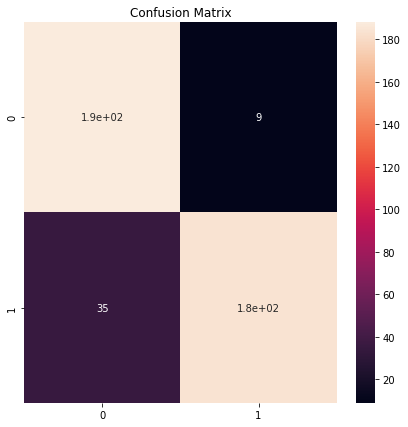


Precision-Recall trade-off report

              precision    recall  f1-score   support

           0       0.84      0.95      0.90       197
           1       0.95      0.84      0.89       219

    accuracy                           0.89       416
   macro avg       0.90      0.90      0.89       416
weighted avg       0.90      0.89      0.89       416



In [ ]:
# Reportes
cm_and_report(test['mask'], predictions)

**Conclusiones**:

Tenemos un modelo que captura con buena precisión los negativos, pero algunos positivos los cataloga igual como no tumor presente. Esto lo podemos observar en el recall, donde, para una predicción de 0, lo tenemos elevado, hasta un 0.95, en cambio, para una predicción de 1, esta métrica baja al 0.84.

Debido a la naturaleza del estudio, bajar la métrica de falsos negativos tiene que ser el objetivo, para lograrlo podemos aplicar una de las siguientes técnicas:

- **Nueva arquitectura:** Podemos seguir probar con una arquitectura diferente del modelo que ayude a encontrar esos falsos negativos, agregar capas, buscar la manera de encontrar nuevos inputs, etc.
- **Cambiar el Threshold de predicción:** El output de la red neuronal es una probabilidad donde, de acuerdo a un threshold podemos determinar si un paciente presenta o no presenta tumor, podemos bajar ese threshold y determinar que, por ejemplo, si el algoritmo arroja que existe un 5% de tener un tumor ya tenerlo como sospechoso y catalogarlo como positivo, esto ayuda a captar la mayor cantidad de verdaderos positivos.

Recordemos que gracias al precision-recall trade-off, si queremos aumentar una de estas métricas, la otra disminuye, en nuestro caso, aumentar el recall para los positivos, sin importar mucho la precisión del modelo.

Bajar los falsos positivos no sería la tarea de mayor relevancia ya que, si el paciente es diagnosticado como positivo, pero realmente no lo es, con un segundo análisis clínico se descartaría el diagnóstico. Haríamos pasar un mal rato al paciente, pero es preferible eso a diagnosticar como falso negativo a alguien que si tenga tumor.

**Comprobando un threshold bajo.**

Usaremos un threshold de 0.5 que nos ayude a disminuir los falsos negativos.

In [ ]:
predictions = make_predictions(model=model, image_paths=image_paths, threshold=0.05)

The accuracy of the model is 0.8557692307692307



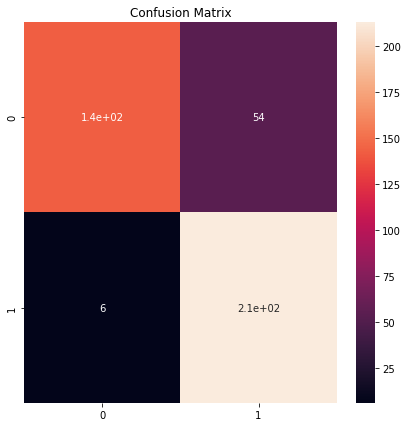


Precision-Recall trade-off report

              precision    recall  f1-score   support

           0       0.96      0.73      0.83       197
           1       0.80      0.97      0.88       219

    accuracy                           0.86       416
   macro avg       0.88      0.85      0.85       416
weighted avg       0.87      0.86      0.85       416



In [ ]:
cm_and_report(test['mask'], predictions)

Gracias a que podemos disponer de cambiar el threshold tenemos ahora una precisión más baja, pero esto, debido a la naturaleza del problema no significa un peor resultado, analicemos los reportes.

* Se han disminuido a 6 los falsos negativos, mientras que los falsos positivos aumentaron a 54. Esto nos ayuda a dar un diagnóstico más certero para cuando realmente estamos en presencia de un tumor, sacrificando a los que dan positivo, pero realmente no lo son.
* Este cambio se traduce en el recall del modelo para una predicción de 1, donde este sube hasta el 97%, un buen resultado.

Recordemos que los modelos de machine learning no son 100% certeros, aunque pueden llegar a ser mejores que los humanos no podemos descartar la experiencia de los mismos, es por ello que una predicción no se puede dar por hecho. Esto hablando en problemas donde la salud está de por medio.

# Entrenamiento de un modelo de segmentación

In [ ]:
# Obtenemos el dataframe que contiene las resonancias magnéticas que tienen máscaras asociadas.
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [ ]:
# Dividir los datos en datos de prueba y de entrenamiento
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [ ]:
# Crear una lista separada para imageId, classId y pasarlos al generador
train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [ ]:
# Agregando data/ al inicio de los paths
train_ids = [f'data/{id}' for id in train_ids]
train_mask = [f'data/{id}' for id in train_mask]

val_ids = [f'data/{id}' for id in val_ids]
val_mask = [f'data/{id}' for id in val_mask]

El archivo de utilidades contiene el código para la función de pérdida personalizada y el generador de datos personalizados


In [ ]:
from utilities import DataGenerator

# Creamos los generadores de imágenes
training_generator = DataGenerator(train_ids, train_mask)
validation_generator = DataGenerator(val_ids, val_mask)

In [ ]:
# Función para escalar y concatenar los valores pasados
def upsample_concat(x, skip):
    '''
    Function to concatenate two layers.
    - This function is used on U-Net architecture 
    **Args:**
    - x: Current layer
    - skip: layer to concatenate to the current layer
    **Returns:**
    - merge: The two layers already concatenated
    '''
    x = UpSampling2D((2,2))(x)
    merge = Concatenate()([x, skip])

    return merge

**Arquitectura del modelo:**

El modelo de segmentación tendrá una arquitectura que se asemeja a las redes ResUNet, para mayor información se puede consultar el correspondiente [paper](https://arxiv.org/pdf/1505.04597.pdf)

**Primera fase:**
- Una capa de convolución con 16 filtros, kernel de 3 y padding same, para mantener el tamaño original, usaremos un iniciador de kernel he-normal.
- Capa de batch normalization
- Una segunda capa de convolución con 16 filtros, kernel de 3 y padding same, para mantener el tamaño original, usaremos un iniciador de kernel he-normal.
- Capa de batch normalization
- Capa de MaxPooling

**Segunda, tercera, cuarta y quinta fase: (Fase de reducción)**
- Usaremos bloques ResNet para estas tres fases, con esto se busca ir disminuyendo el tamaño poco a poco profundizar con 32, 64, 128 y 256 filtros respectivamente.

**Sexta, séptima, octava y novena capa: (Fase de re escalado)**
- En estas capas hacemos los contrario a las anteriores, vamos aumentando el tamaño de la imagen hasta obtener el tamaño original. Aplicamos 128, 64, 32 y 16 filtros respectivamente. Nos ayudamos de la función upsample_concat para unir el resblock aplicado en esta etapa con su respectiva etapa de reducción.


In [ ]:
input_shape = (256,256,3)

# Forma del tensor de entrada
X_input = Input(input_shape)

# Fase 1
conv1_in = Conv2D(16,3,activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation='relu', padding='same', kernel_initializer='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPooling2D(pool_size=(2,2))(conv1_in)

# Fase 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPooling2D(pool_size=(2,2))(conv2_in)

# Fase 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPooling2D(pool_size=(2,2))(conv3_in)

# Fase 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPooling2D(pool_size=(2,2))(conv4_in)

# Fase 5 (Cuello de Botella)
conv5_in = resblock(pool_4, 256)

# Fase de Escalada 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Fase de Escalada 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Fase de Escalada 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Fase de Escalada 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Salida Final
output = Conv2D(1, (1,1), padding="same", activation="sigmoid")(up_4)

model_seg = Model(inputs=X_input, outputs=output)

model_seg.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_150 (Conv2D)            (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_150 (Batch  (None, 256, 256, 16  64         ['conv2d_150[0][0]']             
 Normalization)                 )                                                          

## Entrenamiento del modelo de segmentación

En un problema de segmentación, para evaluar que tan bien el algoritmo está aprendiendo y para determinar la pérdida es necesario utilizar métricas que ayuden cuando un dataset es desbalanceado, es decir, cuando una categoría domina sombre las demás. En nuestro caso, las máscaras son un conjunto de pixeles donde la mayoría de ellos son 0, y pocos son 1, o píxeles de un color diferente.

Si usamos las métricas comunes podemos caer en que el algoritmo no maneje adecuadamente los falsos positivos y falsos negativos, dando lugar a malas predicciones, esto debido a que el algoritmo entendería que, la probabilidad de que un pixel sea negro (0), es mayor a que sea de otro color (1).

Nos ayudaremos de una métrica que está basada en los índices de Tversky, lo que hace esta métrica es penalizar, de acuerdo al dataset a los falsos positivos o negativos para mantener un balance de los mismos. Para mayor información se puede consultar el paper en este enlace. https://arxiv.org/pdf/1706.05721v1.pdf

las métricas están implementadas en el archivo utilities que se importa a continuación. Todo el crédito de las métricas implementadas en Python a Nabs Abraham.

https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py

In [ ]:
from utilities import focal_tversky, tversky_loss, tversky

In [ ]:
# Compilamos el modelo
adam = tf.keras.optimizers.Adam(learning_rate=0.01, epsilon=0.1)
model_seg.compile(optimizer=adam, loss=focal_tversky, metrics=[tversky])

# Guardamos el mejor modelo con menor pérdida de validación
checkpointer_unet = ModelCheckpoint(filepath="ResUNet-weights.hdf5", verbose=1, save_best_only=True)

history = model_seg.fit(training_generator, epochs=30, validation_data=validation_generator,
                        callbacks=[checkpointer_unet, lr_scheduler])

Epoch 1/30
72/72 [==============================] - ETA: 0s - loss: 0.9007 - tversky: 0.1300
Epoch 1: val_loss improved from inf to 0.88962, saving model to ResUNet-weights.hdf5
72/72 [==============================] - 325s 4s/step - loss: 0.9007 - tversky: 0.1300 - val_loss: 0.8896 - val_tversky: 0.1443 - lr: 0.0100
Epoch 2/30
72/72 [==============================] - ETA: 0s - loss: 0.8656 - tversky: 0.1749
Epoch 2: val_loss improved from 0.88962 to 0.85676, saving model to ResUNet-weights.hdf5
72/72 [==============================] - 19s 258ms/step - loss: 0.8656 - tversky: 0.1749 - val_loss: 0.8568 - val_tversky: 0.1861 - lr: 0.0100
Epoch 3/30
72/72 [==============================] - ETA: 0s - loss: 0.8130 - tversky: 0.2409
Epoch 3: val_loss improved from 0.85676 to 0.80934, saving model to ResUNet-weights.hdf5
72/72 [==============================] - 15s 201ms/step - loss: 0.8130 - tversky: 0.2409 - val_loss: 0.8093 - val_tversky: 0.2457 - lr: 0.0100
Epoch 4/30
72/72 [=============

Una ayuda visual para poder observar realmente que es lo que está pasando con nuestro modelo, como aprende y su comportamiento.

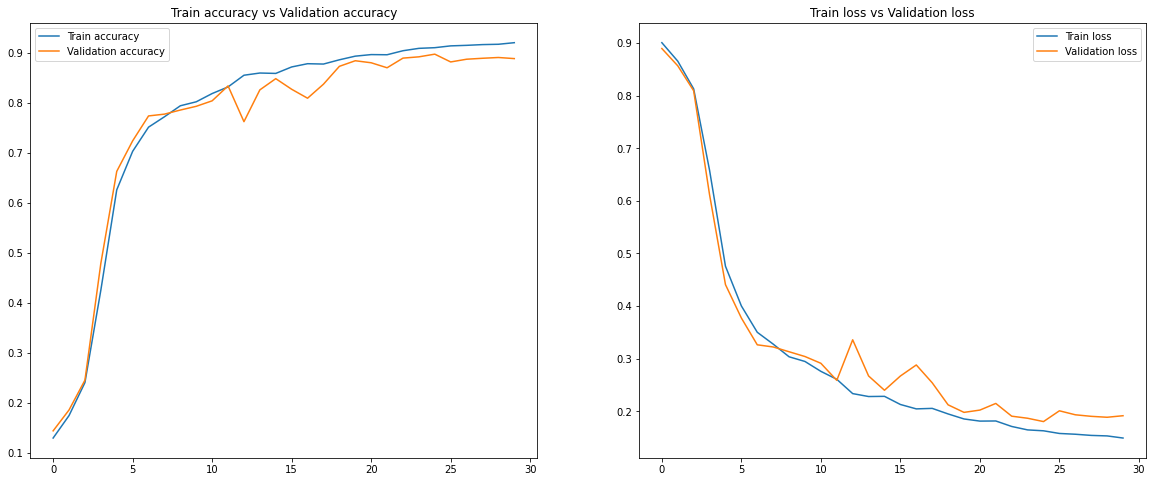

In [ ]:
plot_metrics(history.history)

**Conclusiones:**

* Podemos observar cómo nuestro modelo aprende hasta llegar a un 90% de accuracy, vemos esta tendencia en el conjunto de validación.
* En la gráfica de la derecha vemos como la pérdida disminuye época a época en ambos conjuntos de datos.

In [ ]:
# Guardamos la arquitectura del modelo en un archivo json para uso futuro
model_json = model_seg.to_json()
with open("ResUNet-model.json","w") as json_file:
    json_file.write(model_json)

## Evaluación del modelo

In [ ]:
from utilities import focal_tversky, tversky_loss, tversky

with open('ResUNet-model.json', 'r') as json_file:
    json_savedModel= json_file.read()

model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('ResUNet-weights.hdf5')
adam = tf.keras.optimizers.Adam(learning_rate=0.01, epsilon=0.1)
model_seg.compile(optimizer=adam, loss =focal_tversky, metrics=[tversky])

In [ ]:
# Agregamos /data a los path
test_df = test.copy()
test_df['image_path'] = test_df['image_path'].apply(lambda x: f'data/{x}')
test_df['mask_path'] = test_df['mask_path'].apply(lambda x: f'data/{x}')
test_df.head()

level_0  index                                         image_path  \
231      2242   3534  data/TCGA_DU_7008_19830723/TCGA_DU_7008_198307...   
1137      206    206  data/TCGA_HT_A61B_19991127/TCGA_HT_A61B_199911...   
1303     1014   1095  data/TCGA_DU_7304_19930325/TCGA_DU_7304_199303...   
29       1464   1939  data/TCGA_HT_7602_19951103/TCGA_HT_7602_199511...   
450      2409   3776  data/TCGA_DU_6407_19860514/TCGA_DU_6407_198605...   

                                              mask_path mask  
231   data/TCGA_DU_7008_19830723/TCGA_DU_7008_198307...    0  
1137  data/TCGA_HT_A61B_19991127/TCGA_HT_A61B_199911...    0  
1303  data/TCGA_DU_7304_19930325/TCGA_DU_7304_199303...    0  
29    data/TCGA_HT_7602_19951103/TCGA_HT_7602_199511...    0  
450   data/TCGA_DU_6407_19860514/TCGA_DU_6407_198605...    0

In [ ]:
def predictions_2_models(model, seg_model, image_paths, threshold=0.5):
    '''
    Funtion to make predictions according the classification model already trained.
    **Args**:
    * model: Clasification model already trained
    * seg_model: Segmentation model already trained
    * image_paths: The path where the images are saved,
    * threshold: For binary classification models, threshold to be take in care to decide if
    a prediction is 1 or 0.
    **Returs**:
    It returns a list of prediction, 0 or 1 in string format due flow from dataset test_generator
    ''' 
    mask = [] 
    has_mask = []
    image_id = []
    count = 0
    for path in image_paths:
        # Leemos la imágen y normalizamos sus valores
        img = io.imread('./data/{}'.format(path))
        img = img / 255.
        # Transformamos la imágen a tensor de la forma [m, h, w, c]
        img = tf.reshape(img, shape=[1, img.shape[0], img.shape[1], img.shape[2]])
        # Aplicamos la predicción
        pred = model.predict(img)
        # Guardamos 0 o 1 de acuerdo a la probabilidad.
        if pred[0][0] <= threshold:
            image_id.append(count)
            has_mask.append(0)
            mask.append('No mask')
            count += 1
            continue

        # leemos la imagen
        img = io.imread('./data/{}'.format(path))

        # Creamos un array bacío de forma 1,256,256,1
        X = np.empty((1, 256, 256, 3))

        # Re dimencionar la imagen y convertirla a float64
        img = cv2.resize(img,(256,256))
        img = np.array(img, dtype = np.float64)

        # Standarización de la imagen
        img -= img.mean()
        img /= img.std()

        # Redimensionando la imagen de 256,256,3 a 1,256,256,3
        X[0,] = img

        # Hacer la predicción
        predict = model_seg.predict(X)

        # Si la suma de la máscara es cero, no hay tumor
        if predict.round().astype(int).sum() == 0:
            image_id.append(count)
            has_mask.append(0)
            mask.append('No mask')
        else:
        # Si la suma es mayor a cero, guardamos la máscara
            image_id.append(count)
            has_mask.append(1)
            mask.append(predict)

        count += 1

    return image_id, mask, has_mask

In [ ]:
df_test = test[['image_path', 'mask_path', 'mask']].reset_index()
image_paths = df['image_path'].to_list()

Ya tenemos entrenados ambos modelos, ahora podemos evaluar con el conjunto de testing como nuestro modelo trabaja.

1. Pasaremos las imágenes por el modelo de clasificación, esto nos ayudará a determinar si hay o no presencia de tumor.
2. Si hay presencia de tumor, esa imagen pasa al modelo de segmentación, este es el encargado de predecir la máscara tratando de encontrar la localización del tumor.

In [ ]:
image_id, mask, has_mask = predictions_2_models(model_res, model_seg, image_paths, threshold=0.5)

In [ ]:
# Creamos el dataframe para el resultado
df_pred = pd.DataFrame({'image_path': image_paths,
                        'mask_path' : df_test['mask_path'].to_list(),
                        'predicted_mask': mask,
                        'has_mask': has_mask})
df_pred.head()

image_path  \
0  TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_44...   
1  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_2.tif   
2  TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_10...   
3  TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_18...   
4  TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_56...   

                                           mask_path  \
0  TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_44...   
1  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_2_...   
2  TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_10...   
3  TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_18...   
4  TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_56...   

                                      predicted_mask  has_mask  
0                                            No mask         0  
1                                            No mask         0  
2                                            No mask         0  
3  [[[[7.03549e-05], [9.556252e-05], [0.00014688]...         1  
4                                            No mask         0

Para mejor entendimiento dibujaremos unas imágenes donde:

* Visualizaremos la imagen original de la resonancia magnética.
* Visualizaremos la máscara para esa imagen y la sobrepondremos a la resonancia.
* Haremos lo mismo, pero con la máscara que nuestro modelo predijo.

Visualmente podremos corroborar que tan bien nuestro modelo puede llegar a localizar tumores cerebrales.

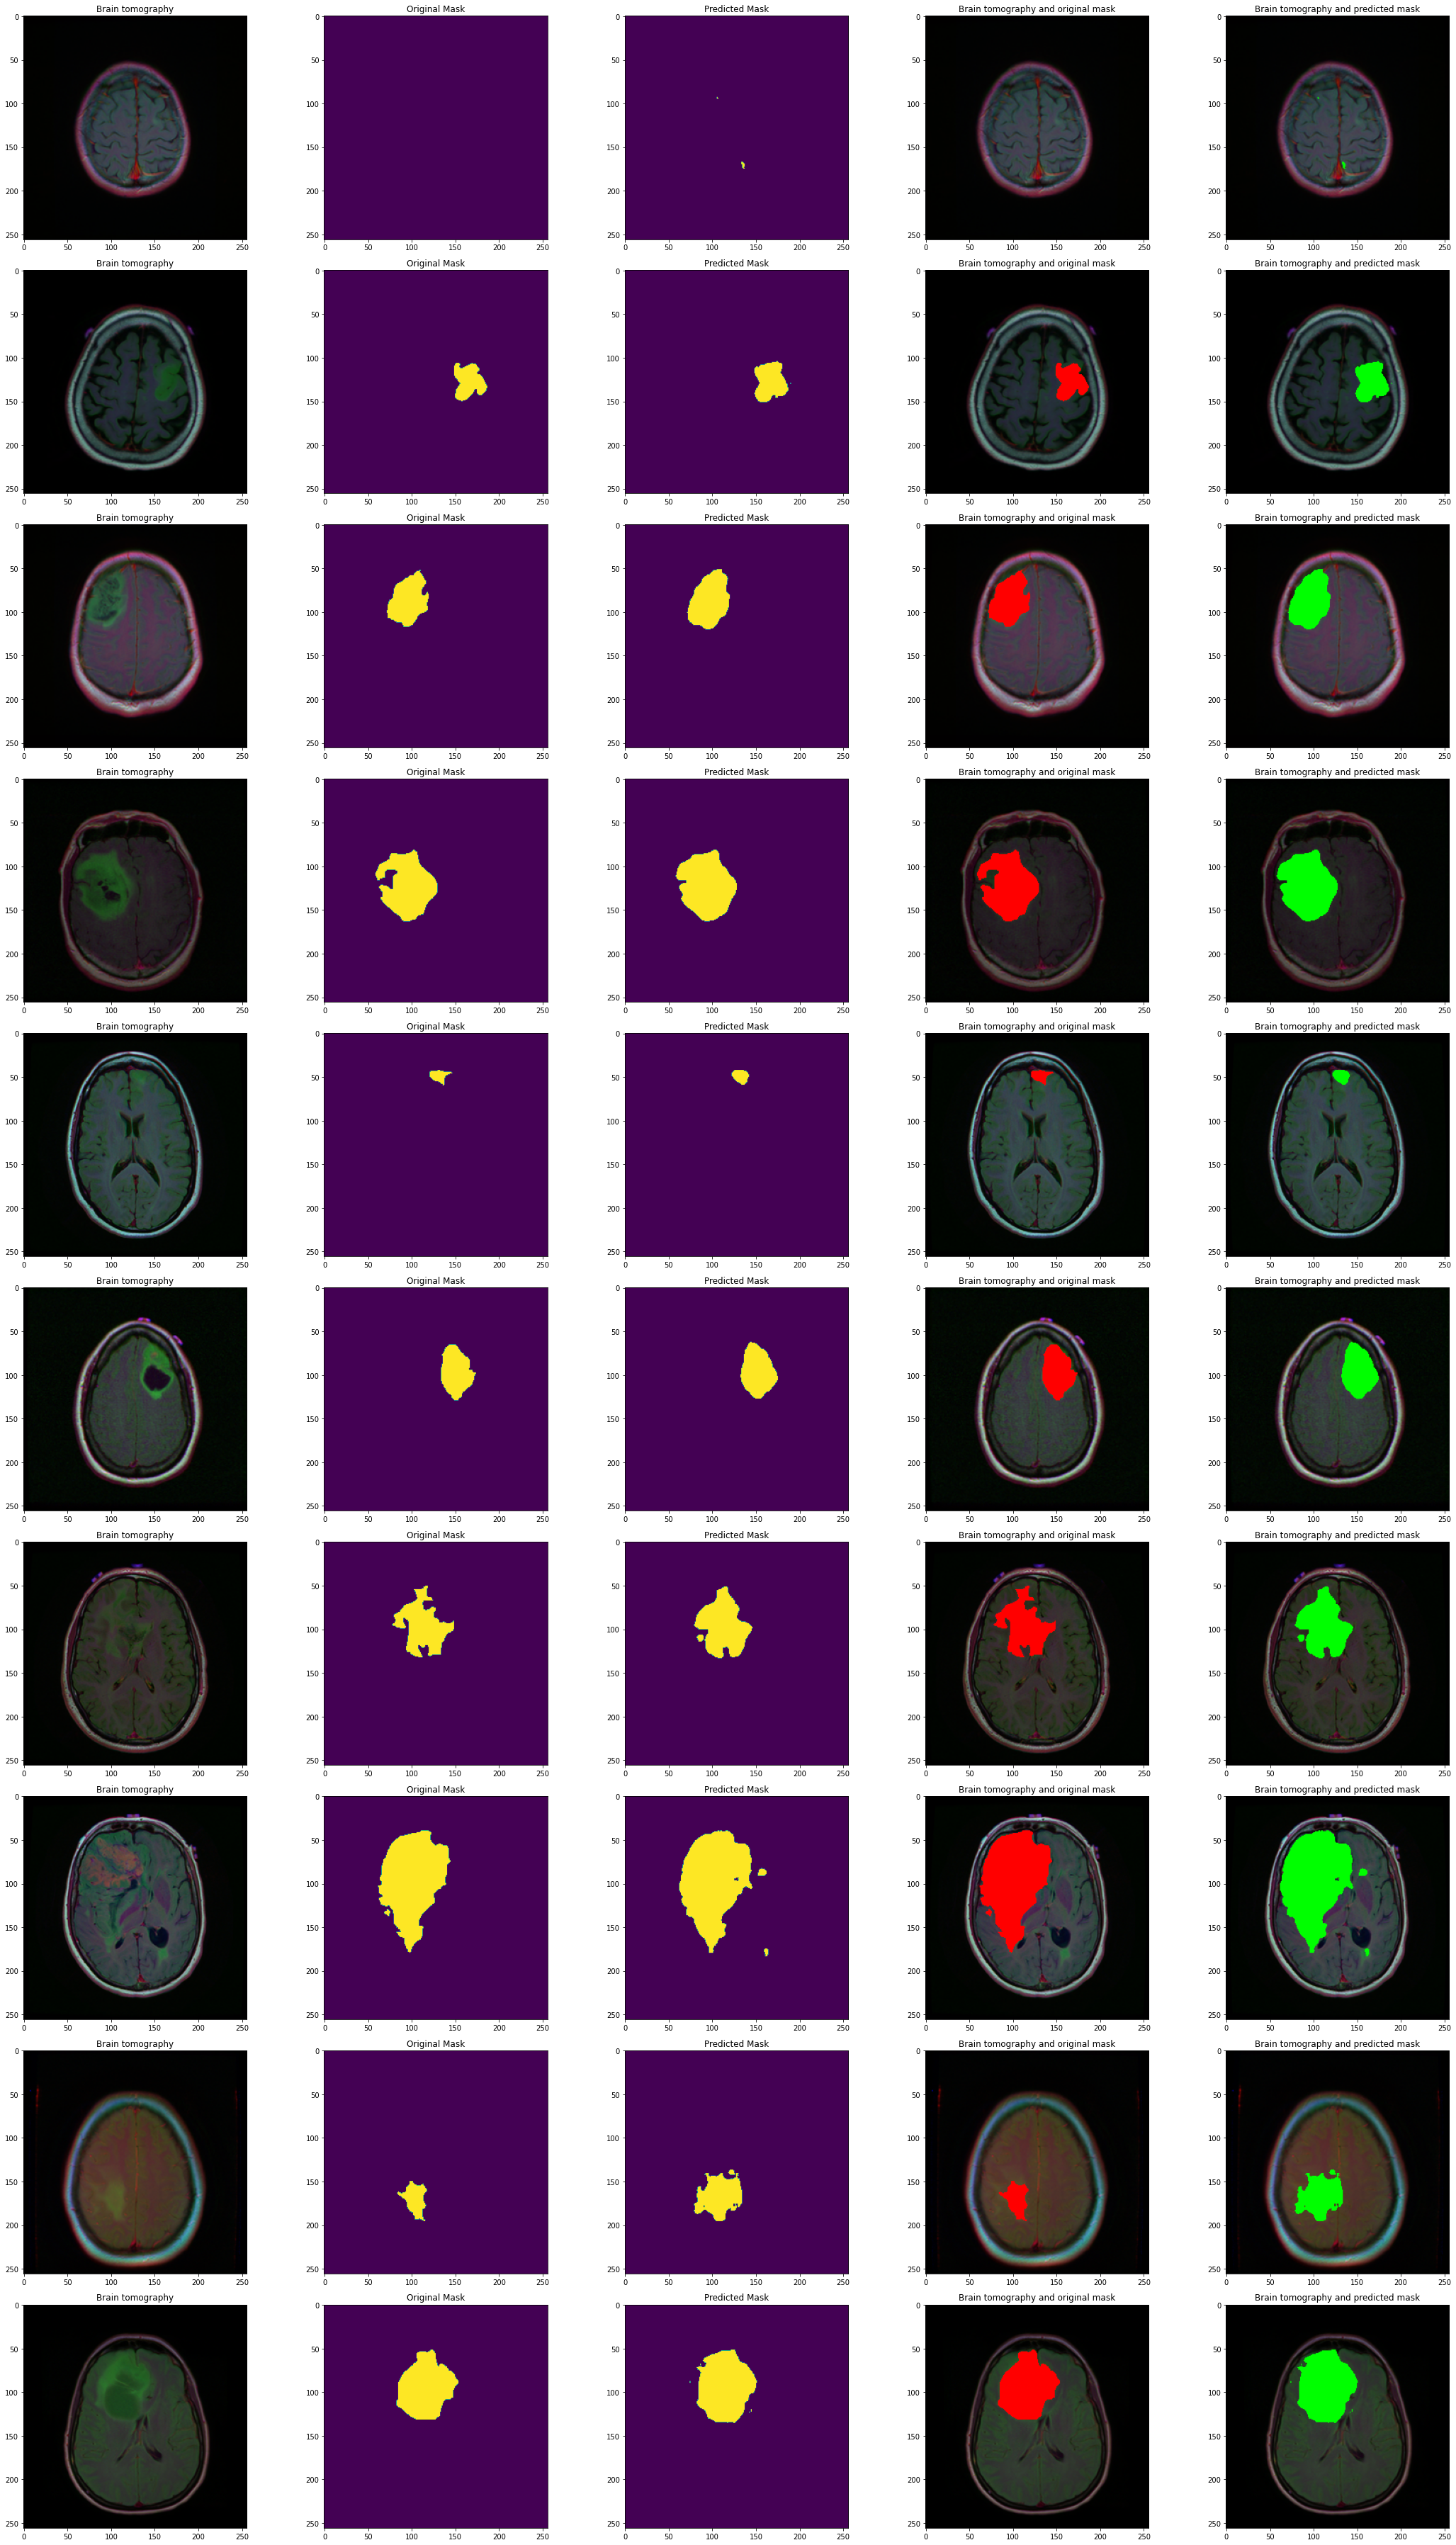

In [ ]:
count = 0 
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
    if df_pred['has_mask'][i] == 1 and count < 10:
    # leer las imágenes y convertirlas a formato RGB
    img = io.imread(f'./data/{df_pred.image_path[i]}')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain resonance")
    axs[count][0].imshow(img)

    # Obtenemos la máscara para la imagen
    mask = io.imread(f'./data/{df_pred.mask_path[i]}')
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtenemos la máscara de predicción para dicha imagen
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("Predicted Mask")
    axs[count][2].imshow(predicted_mask)

    # Aplicamos la máscara a la imagen 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("Brain resonance and original mask")
    axs[count][3].imshow(img)

    img_ = io.imread(f'./data/{df_pred.image_path[i]}')
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("Brain resonance and predicted mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()

**Conclusiones:**

Podemos observar como ahora ambos modelos trabajan en conjunto para llegar a un resultado.

1. El primer modelo predice la presencia de tumor.
2. El segundo modelo predice, por medio de una máscara, la localización del mismo.

Gracias al avance de este tipo de algoritmos podemos diagnosticar de una forma temprana la presencia de anormalidades en el organismo humano, esto ayudará a poder aplicar un tratamiento temprano.